In [ ]:
!pip install pandas-profiling
!pip install seaborn

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures    # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score    # function to calculate mean squared error 

# Privacy-preserving occupancy counting

March 2022

# Introduction

Previously I have worked on [TinyML as-a-Service](https://ieeexplore.ieee.org/document/9427352) project, *running Machine Learing (ML) inferences on microcontrollers in tiny IoT sensors*, which unlock the power of ML without Cloud computing. I have been looking for a TinyML killer usecase in real life. One of such usecases may be a **privacy-preserving occupancy count device**. Although occupancy counting itself can be done with camera devices, it uploads enomous amount of raw data of recordings on Cloud. Then, those data is proccessed heavily by ML on Cloud GPU. Basically We don't want to expose our privacy data out of our premises. Uploading onto Cloud always has a risk of leaking such data, compared with local processing within sensor devices. Uploading also comes with communication cost, for example, via 5G cellular. My proposal is to enable "people counting in a room with a IoT sensor". ML inference on IoT deivce processes primitive raw data (ex: CO2 emission) locally to detect number of people in a room. People emits CO2. The potential customers of this device may be building maintenance companies (i.e. smart building).They could:

1.   maximize room usage rate by allocating suitable spaces for group of people
2.  reduce energy consumption by controlling lights bulbs and air conditioners for group of people

In shared sauna (yes, here's Finland), for example, the current space availability could be checked online before you go naked. In sauna, people are naked and they can talk about thier secrets in relaxed mood. So privacy matters a lot and we don't want any real sensors installed at all. Probably measuring CO2 emission is acceptable in most of the places. This IoT sensor could be also used to check if your eldery parents are still breathing in your home town. This TinyML device may have bluetooth or Wi-fi connection to send only a single 1 byte of data(number of people, 0-256) occassionally, compared with Giga byte of recording data. This pre-processed information (number of people) doesn't include privacy and uploading cost is cheap.

The ML problem is explained in more detail in the [Problem Formulation](#Problem-Formulation) section.
The [Methods](#Methods) section describes the used dataset and regression methods. The different methods are
compared in the [Results](#Results) section. The [Conclusions](#Conclusions) section contains discussion on the usefulness of the
ML model and some directions for future development.

# Problem Formulation


<!---
* Formalise the application an ML problem.  
* Clearly explain the data points, features and labels of this ML problem
* Explain the source of the dataset
--->
CO2 sensor in a room measures how much CO2 in a room as time passes. ML would detect number of people in a room with amount of emitted CO2. Here's a [Kaggle dataset](https://www.kaggle.com/ananthr1/room-occupancy-estimation-data-set). This dataset is composed of several sensor data. They are CO2, lights on/off, temperature, motion detector and sound. The datapoint is considered **state of a room** at certain time. I picked up **amount of CO2 emission** as a main feature. The rest of sensor data could be used too to complement if CO2 is not enough. The label is **number of people** in a room. The fewer sensors used, the better for TinyML because of the limited computational resources on microcontrollers. How to shrink ML model size fitting in a small microcontroller is out of this course scope.

# Method

## Datapoints
<!---State the number of datapoints, briefly describe the dataset and/or any data preprocessing needed--->
The data is collected from the size of a room, 6m x 4.6m. The number of datapoints is 10,129 without any missing values. 7 sensor nodes transmit almost every 30s via wireless transceivers. Each attribute of sensors:
- Date: YYYY/MM/DD
- Time: HH:MM:SS
- Temperature: In degree Celsius (S1_Temp, S2_Temp, S3_Temp)
- Light: In Lux (S1_Light, S2_Light, S3_Light, S4_Light)
- Sound: In Volts (amplifier output read by ADC) (S1_Sound, S2_Sound, S3_Sound, S4_Sound)
- CO2: In PPM (S5_CO2)
- CO2 Slope: Slope of CO2 values taken in a sliding window (S5_CO2_Slope)
- PIR: Binary value conveying motion detection (S6_PIR, S7_PIR)
- RoomOccupancyCount: Ground Truth (Room_Occupancy_Count)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/doyu/people_count_in_room/main/Occupancy_Estimation.csv')
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [ ]:
#df.info()

In [ ]:
#profile = ProfileReport(df)
#profile
#profile.to_file("Analysis.html")

In [ ]:
df.corr()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
S1_Temp,1.000000,0.799707,0.948839,0.855279,0.680743,0.548735,0.645163,0.212217,0.436099,0.391137,0.438769,0.355826,0.866718,0.137391,0.436363,0.474077,0.700868
S2_Temp,0.799707,1.000000,0.765525,0.696581,0.639773,0.645987,0.607349,0.370897,0.438274,0.409545,0.427133,0.378724,0.743722,0.202547,0.476901,0.465884,0.671263
S3_Temp,0.948839,0.765525,1.000000,0.885186,0.594311,0.500054,0.642601,0.301419,0.375183,0.344026,0.398177,0.326182,0.821308,0.095842,0.403355,0.460309,0.652047
S4_Temp,0.855279,0.696581,0.885186,1.000000,0.581482,0.456350,0.588459,0.386871,0.355111,0.312594,0.340808,0.294939,0.650320,0.106208,0.340000,0.339037,0.526509
S1_Light,0.680743,0.639773,0.594311,0.581482,1.000000,0.842090,0.816438,0.510853,0.601166,0.534274,0.494080,0.441712,0.602740,0.498185,0.607159,0.545213,0.849058
S2_Light,0.548735,0.645987,0.500054,0.456350,0.842090,1.000000,0.709579,0.458914,0.503021,0.560630,0.439269,0.413932,0.566764,0.493281,0.554658,0.556797,0.788764
S3_Light,0.645163,0.607349,0.642601,0.588459,0.816438,0.709579,1.000000,0.579484,0.502606,0.434859,0.577151,0.473606,0.650829,0.447708,0.501836,0.577815,0.793081
S4_Light,0.212217,0.370897,0.301419,0.386871,0.510853,0.458914,0.579484,1.000000,0.293632,0.303949,0.169702,0.200793,0.148608,0.212718,0.324545,0.220196,0.355715
S1_Sound,0.436099,0.438274,0.375183,0.355111,0.601166,0.503021,0.502606,0.293632,1.000000,0.560062,0.540736,0.557733,0.391903,0.335772,0.522015,0.463040,0.573748
S2_Sound,0.391137,0.409545,0.344026,0.312594,0.534274,0.560630,0.434859,0.303949,0.560062,1.000000,0.529830,0.578635,0.333836,0.357235,0.485697,0.507231,0.557853


## Feature selection
All of 3 temperature sensors are correlated so that only _S1_Temp_, which is most correlated to _target_, was chosen.  All of 3 light sensors are correlated so that only _S1_Light_, which is most correlated to _target_, was chosen. All of sound sensors are dropped here because of privacy reason. We started with S1_Temp, S1_Light, S5_CO2, S5_CO2_Slope, S6_PIR, and S7_PIR.

<AxesSubplot:>

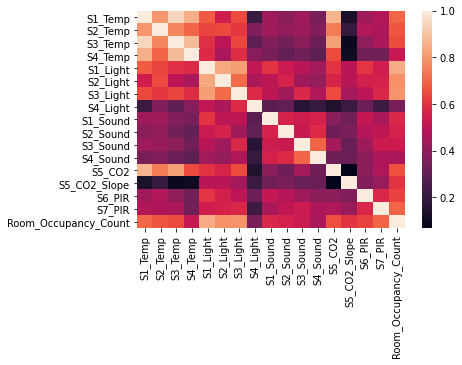

In [ ]:
sns.heatmap(df.corr())

In [ ]:
#df.columns
df = df[['S1_Temp', 'S1_Light', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count']]
df.head()

,S1_Temp,S1_Light,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,121,390,0.769231,0,0,1
1,24.94,121,390,0.646154,0,0,1
2,25.00,121,390,0.519231,0,0,1
3,25.00,121,390,0.388462,0,0,1
4,25.00,121,390,0.253846,0,0,1


## Model
<!---Describe and explain (why?) your choice of ML model(s)/hypothesis space(s)*,
e.g., linear predictors, etc-->
We tried Logistic regression with different polynominal orders to find out the best of it. The reason is that the 

In [ ]:
#%%timeit
def poly_scores(degrees, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scores = []
    for i in degrees:
        model = LinearRegression(fit_intercept=False)
        poly = PolynomialFeatures(degree=i)
        skf = StratifiedKFold()
        x = cross_val_score(model, poly.fit_transform(X_train), y_train, cv=skf)
        #print(i, x)
        scores.append(np.mean(x))

    return scores

def test_accuracy(degree, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    model = LinearRegression(fit_intercept=False).fit(X_train_poly, y_train)
    y = model.predict(poly.fit_transform(X_test))
    y = list(map(round, y))
    return sum(y==y_test) / len(y)

In [ ]:
# 'S1_Temp', 'S1_Light', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'
y = df['Room_Occupancy_Count']
X6 = df[['S1_Temp', 'S1_Light', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']]
X5 = df[['S1_Temp', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']]
X4 = df[['S1_Temp', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR']]
X3 = df[['S5_CO2', 'S5_CO2_Slope', 'S6_PIR']]
X2 = df[['S5_CO2', 'S5_CO2_Slope']]
X1 = df[['S5_CO2']]

degrees = range(1,6)
scores = {'poly degree':degrees}
accs = []

for i, X in enumerate([X6, X5, X4, X3, X2, X1]):
    tmp = poly_scores(degrees, X, y)
    scores[f"X{6-i}"] = tmp
    idx = np.argmax(tmp)
    #print(idx, degrees[idx])
    acc = test_accuracy(degrees[idx], X, y)
    accs.append(acc)

In [ ]:
d = pd.DataFrame({k: pd.Series(v) for k, v in scores.items()})
d = d.set_index('poly degree')
d
#d.style.applymap(lambda x: "background-color: yellow" if x==np.max(d['score']) else "background-color: white")

,X6,X5,X4,X3,X2,X1
poly degree,,,,,,
1,0.870882,0.834788,0.817154,0.796813,0.751911,0.445135
2,0.936174,0.865012,0.837572,0.820712,0.767796,0.452824
3,0.955366,0.899802,0.875181,0.839125,0.799765,0.461071
4,0.949246,0.886663,0.882610,0.841926,0.813125,0.461860
5,0.790045,0.642105,0.761449,0.502662,0.807503,0.459508


<AxesSubplot:xlabel='poly degree', ylabel='coefficient of determination'>

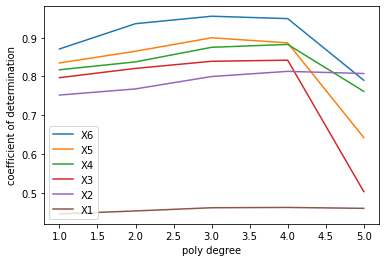

In [ ]:
d.plot(xlabel='poly degree', ylabel='coefficient of determination')

In [ ]:
d = pd.DataFrame({'accuracy':accs, 'features':['X6','X5','X4','X3','X2','X1']})
d = d.set_index('features')
d
#d.style.applymap(lambda x: "background-color: yellow" if x==np.max(d['score']) else "background-color: white")

,accuracy
features,
X6,0.977624
X5,0.925962
X4,0.923330
X3,0.902600
X2,0.890424
X1,0.737743


<AxesSubplot:xlabel='features'>

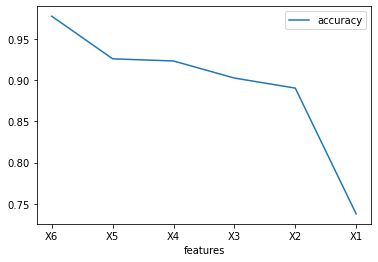

In [ ]:
d.plot()

## Loss function
<!---Describe and explain (why?) your choice of loss function(s)*, e.g., logistic loss--->
Since "room_occupany" (_target_) can take only 4 values as seen below, this can be considered a multi-class problem. We use logistic loss.

<AxesSubplot:>

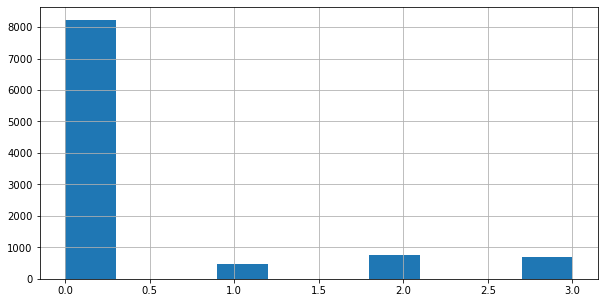

In [ ]:
target = 'Room_Occupancy_Count'
df[target].hist(figsize=(10,5))

## Validation
Explain the process of model validation
- how did you split the data into training, validation and test sets. 
- What are the sizes of each set and why did you make such design choice

# References
- dataset, https://www.kaggle.com/ananthr1/room-occupancy-estimation-data-set
- notebook, https://github.com/doyu/people_count_in_room/blob/main/people_count_in_room.ipynb